In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from hdbscan import HDBSCAN, approximate_predict
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from matplotlib import pyplot as plt
import joblib
import json
import os
import cv2
from matplotlib import cm


In [2]:
def pca_clustering(data, method_reduction='pca', n_components=2, method_cluster = 'kmeans', n_clusters=4):
    # Apply dimensionality reduction
    if method_reduction == 'pca':
        drmethod = PCA(n_components=n_components, random_state=0)
    else:
        raise ValueError("Invalid method. Choose 'pca'.")
    
    reduced_data = drmethod.fit_transform(data)
    
    # Clusterize the reduced data
    if 'kmeans' in method_cluster:
        clmethod = KMeans(n_clusters=n_clusters, random_state=0, verbose= 2, algorithm = 'elkan')
    elif 'dbscan' in method_cluster:
        clmethod = DBSCAN(eps=0.3, min_samples=100)
    elif 'hdbscan' in method_cluster:
        clmethod = HDBSCAN(min_cluster_size=100, prediction_data = True)
    else:
        raise ValueError("Invalid method. Choose 'kmeans', 'dbscan' or 'hdbscan'.")
    
    print('Cluster method applied to reduced data')
    clmethod.fit(reduced_data)
    
    # print(f'TRAIN CLUSTERS CENTER: {clmethod.cluster_centers_}')
    print(f'TRAIN CLUSTER LABELS: {clmethod.labels_}')
    print(clmethod)
    
    # Save the model
    joblib.dump(clmethod, 'cluster_train_radiomics.pkl')
    #save the dimensionality reduction model
    joblib.dump(drmethod, 'pca_train_radiomics.pkl')
    
    return reduced_data, drmethod, clmethod


In [3]:
#image data path 
datapath = '/mnt/atlas/data_KPIs/data/KPIs24_Training_Data/Task1_patch_level/train/'
results_path = '/home/benito/script/KPIs24/results/glomeroulous_features/radiomics_analysis/'
os.makedirs(results_path, exist_ok=True)

#define parameters
cluster_method = 'kmeans'
n_clusters = 4
reduction_method = 'pca'

### read csv file
df = pd.read_csv('/home/benito/script/KPIs24/results/glomeroulous_features/radiomics_features_entire_train_patches_by_glomeruli_updated.csv')
# #remove wavelet features
# df = df[df.columns.drop(list(df.filter(regex='wavelet')))]
# #remove shape features
# df = df[df.columns.drop(list(df.filter(regex='shape')))]
df.reset_index(drop=True, inplace=True)

#remove small components
df = df[df['n_foreground_pixels']>1000]
df.reset_index(drop=True, inplace=True)
#remove nan values
df = df.dropna()

#normalize data (z-score) in the train and apply to the test
df_norm = df.copy()
#save mean and std for each column to be used in the test
mean_std = {}
for column in df.columns[3:]:
    mean = df[column].mean()
    std = df[column].std()
    df_norm[column] = (df[column] - mean) / std
    mean_std[column] = [mean, std]

#save mean and std for each column to be used in the test
with open('mean_std_train_radiomics.json', 'w') as json_file:
    json.dump(mean_std, json_file)

In [4]:
# df[df['n_foreground_pixels']>3000]['n_foreground_pixels'].hist(bins=1000, figsize=(10,10))
# #show distribution of ech column of df
# df['n_foreground_pixels'].hist(bins=1000, figsize=(20,15))


In [5]:
# Train the model
pca_data, dimensionality_reduction_model, cluster_model = pca_clustering(df_norm.iloc[:,3:], method_reduction=reduction_method, n_components=3, method_cluster = cluster_method, n_clusters=n_clusters)

Cluster method applied to reduced data
Initialization complete
Iteration 0, inertia 3946838.391483867
Iteration 1, inertia 3065455.252785484
Iteration 2, inertia 2921395.7584622814
Iteration 3, inertia 2865877.5201436854
Iteration 4, inertia 2836252.579526915
Iteration 5, inertia 2814956.1984846247
Iteration 6, inertia 2794092.0344383
Iteration 7, inertia 2777974.4853657912
Iteration 8, inertia 2763447.3245776887
Iteration 9, inertia 2751620.7489952194
Iteration 10, inertia 2742674.747282457
Iteration 11, inertia 2733586.853248204
Iteration 12, inertia 2727002.1820468022
Iteration 13, inertia 2721276.610071205
Iteration 14, inertia 2715783.8727246136
Iteration 15, inertia 2710423.209839837
Iteration 16, inertia 2705940.2404738646
Iteration 17, inertia 2701474.7008172413
Iteration 18, inertia 2697694.363535921
Iteration 19, inertia 2694415.970557157
Iteration 20, inertia 2692154.1690390147
Iteration 21, inertia 2690124.196540574
Iteration 22, inertia 2688257.559735516
Iteration 23, iner

In [6]:
df_pca_data = df.iloc[:,:3]
df_pca_data.reset_index(drop=True, inplace=True)
df_pca_data = pd.concat([df_pca_data, pd.DataFrame(pca_data, columns=[f'pca{i}' for i in range(pca_data.shape[1])])], axis=1)
#associate to each point its cluster calculated with the cluster model
df_pca_data['cluster'] = cluster_model.labels_
df_pca_data['n_foreground_pixels'] = df['n_foreground_pixels']

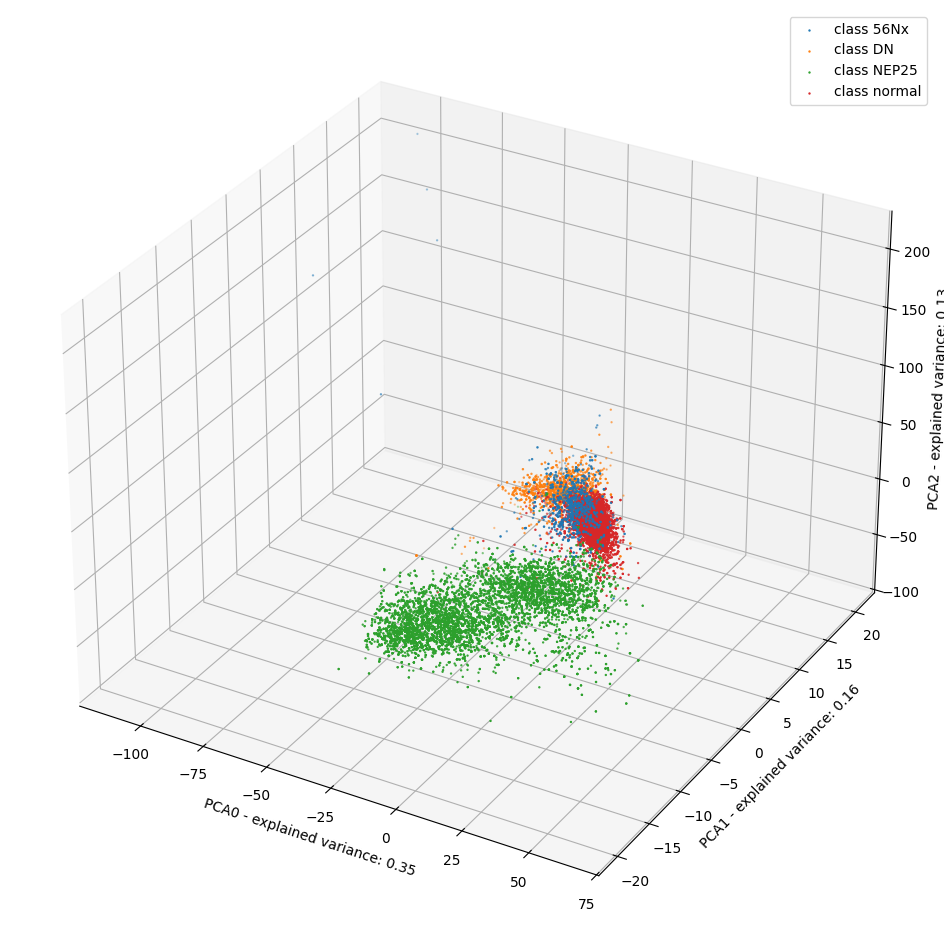

In [7]:
### scatter plot stratiying by class
fig = plt.figure(figsize=(12, 12))
if pca_data.shape[1] == 2:
    ax = fig.add_subplot()
    for i, class_glom in enumerate(df_pca_data['class'].unique()):
        ax.scatter(df_pca_data[df_pca_data['class'] == class_glom]['pca0'], df_pca_data[df_pca_data['class'] == class_glom]['pca1'], label=f'class {class_glom}', s=0.5)
    ax.set_xlabel(f'PCA0 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
    ax.set_ylabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
else:
    ax = fig.add_subplot(projection='3d')
    for i, class_glom in enumerate(df_pca_data['class'].unique()):
        ax.scatter(df_pca_data[df_pca_data['class'] == class_glom]['pca0'], df_pca_data[df_pca_data['class'] == class_glom]['pca1'], df_pca_data[df_pca_data['class'] == class_glom]['pca2'], label=f'class {class_glom}', s=0.5)
    #add axis labels to the plot
    ax.set_xlabel(f'PCA0 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
    ax.set_ylabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
    ax.set_zlabel(f'PCA2 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[2]:.2f}')
ax.legend()
#save the plot
plt.savefig(results_path + 'pca_clusters_by_class.png')
plt.show()


In [8]:
cluster_model.cluster_centers_

array([[-13.59879653,   8.3894787 ,   2.60176742],
       [ 15.96800679,  -6.6940633 ,   1.08853202],
       [-12.0263551 , -12.26970583,  -0.87873082],
       [  3.68767399,   5.53455794,  -0.99481095]])

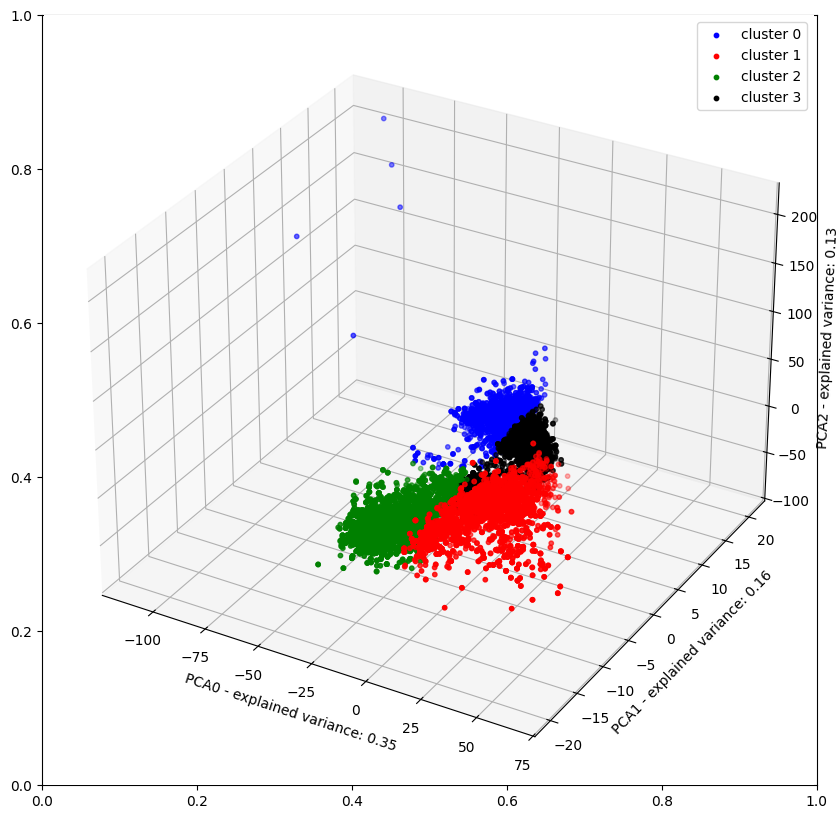

In [9]:
### scatter plot stratiying by cluster
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['blue', 'red', 'green', 'black']

colors = (['black'] + list(cm.tab10(np.linspace(0, 1, df_pca_data['cluster'].unique().shape[0] -1)))  if 'dbscan' in cluster_method  else  ['blue', 'red', 'green', 'black', 'gray', 'purple'])

if pca_data.shape[1] == 2:
    ax = fig.add_subplot()
    for i, cluster in enumerate(sorted(df_pca_data['cluster'].unique())):
        ax.scatter(df_pca_data[df_pca_data['cluster'] == cluster]['pca1'], df_pca_data[df_pca_data['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=(1 if cluster == -1 else 10))
        ax.set_xlabel(f'PCA0 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
        ax.set_ylabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
elif pca_data.shape[1] == 3:
    ax = fig.add_subplot(projection='3d')
    for i, cluster in enumerate(sorted(df_pca_data['cluster'].unique())):
        ax.scatter(df_pca_data[df_pca_data['cluster'] == cluster]['pca0'], df_pca_data[df_pca_data['cluster'] == cluster]['pca1'], df_pca_data[df_pca_data['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=(1 if cluster == -1 else 10))
        ax.set_xlabel(f'PCA0 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
        ax.set_ylabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
        ax.set_zlabel(f'PCA2 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[2]:.2f}')
else:
    raise ValueError('Invalid number of components')

ax.legend()

if cluster_method == 'kmeans':
    for i, cluster in enumerate(cluster_model.cluster_centers_):
        ax.scatter(cluster[0], cluster[1], c='violet', s=10)
        plt.annotate(f'cluster {i}', (cluster[0], cluster[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=15)
#save the plot
plt.savefig(results_path + 'pca_clusters_by_kmeans.png')

plt.show()


In [10]:
#calculate the distance of the test data to the cluster centers
closest_cluster, distances_values = pairwise_distances_argmin_min(pca_data, cluster_model.cluster_centers_)
print(f'CLOSEST CLUSTER: {closest_cluster}' )
print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances_values}')
distances_train_df = pd.DataFrame()
distances_train_df['id'] = df_pca_data['id']
distances_train_df['class'] = df_pca_data['class']
distances_train_df['id_patch'] = df_pca_data['id_patch']
distances_train_df['distance'] = distances_values
distances_train_df['cluster'] = df_pca_data['cluster']
distances_train_df['pca1'] = df_pca_data['pca1']
distances_train_df['pca2'] = df_pca_data['pca2']
distances_train_df['n_foreground_pixels'] = df_pca_data['n_foreground_pixels']
distances_train_df.describe()


CLOSEST CLUSTER: [3 3 0 ... 3 3 3]
DISTANCES BETWEEN CLUSTERS CENTERS: [12.55864827 12.55864827  3.79864216 ...  5.59915401  3.03595551
  1.90940703]


,distance,cluster,pca1,pca2,n_foreground_pixels
count,20310.000000,20310.000000,2.031000e+04,2.031000e+04,2.031000e+04
mean,9.208956,1.933136,-5.373676e-16,8.956127e-17,4.514018e+04
std,6.459851,1.127222,8.681974e+00,7.980099e+00,3.743988e+04
min,0.327715,0.000000,-1.995162e+01,-8.146984e+01,1.022000e+03
25%,5.266693,1.000000,-7.620668e+00,-3.724643e+00,2.381425e+04
50%,8.002906,2.000000,4.696189e+00,5.601779e-02,3.841300e+04
75%,11.643277,3.000000,7.144442e+00,3.751159e+00,5.542200e+04
max,226.421381,3.000000,2.050749e+01,2.107043e+02,1.334575e+06


In [11]:
#clusters identified by kmeans
if cluster_method == 'kmeans':
    dists_clusters = euclidean_distances(cluster_model.cluster_centers_)
    print(f'DISTANCE BETWEEN CLUSTERS: {dists_clusters}')

DISTANCE BETWEEN CLUSTERS: [[ 0.         33.22648009 21.00924428 17.88597248]
 [33.22648009  0.         28.61192426 17.45525906]
 [21.00924428 28.61192426  0.         23.74733655]
 [17.88597248 17.45525906 23.74733655  0.        ]]


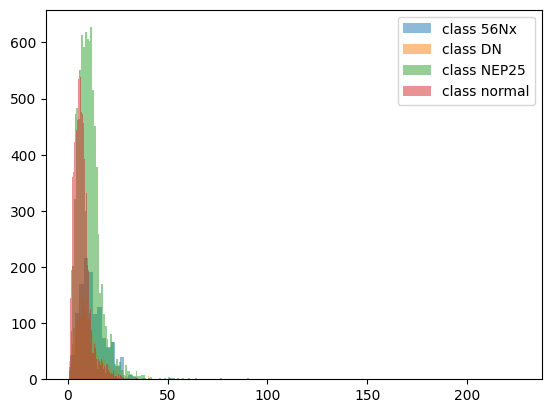

In [12]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_pca_data['class'].unique())):
    ax.hist(distances_train_df[distances_train_df['class'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'class {class_glom}')
ax.legend() 
plt.savefig(results_path + 'hist_distances_to_clusters_by_class.png')
plt.show()


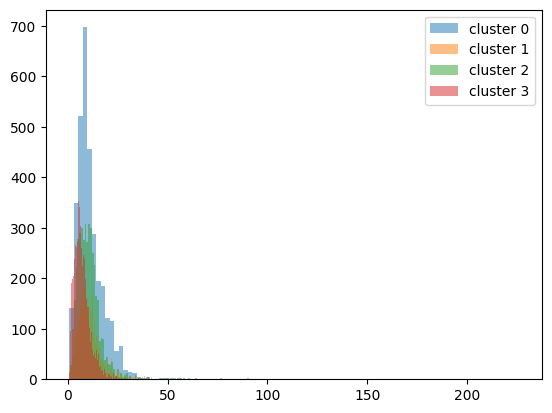

In [13]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_pca_data['cluster'].unique())):
    ax.hist(distances_train_df[distances_train_df['cluster'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'cluster {class_glom}')
ax.legend() 
#save the plot
plt.savefig(results_path + 'hist_distances_to_clusters_by_clusters.png')
plt.show()


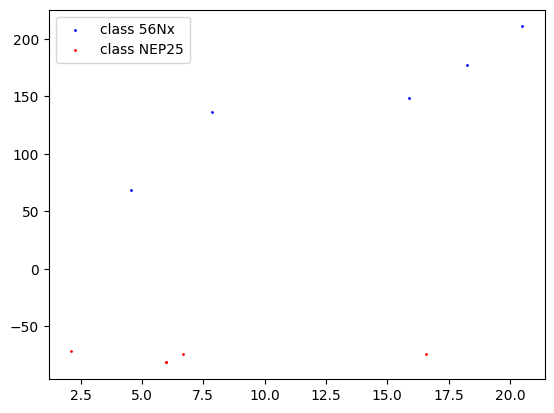

In [14]:
#image to check: get the images with the highest distance to the cluster centers and check if they are outliers
distances_train_df.sort_values(by='distance', ascending=False, inplace=True)
distances_train_df.reset_index(drop=True, inplace=True)

#check the images with the highest distance to the cluster centers
df_train_outliers = distances_train_df.head(10)

#scatter plot of the outliers
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_train_outliers['class'].unique())):
    ax.scatter(df_train_outliers[df_train_outliers['class'] == class_glom]['pca1'], df_train_outliers[df_train_outliers['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()
plt.show()



In [15]:
df_train_outliers

,id,class,id_patch,distance,cluster,pca1,pca2,n_foreground_pixels
0,12_170,56Nx,56Nx_12_170_354_6144_12288_mask_2,226.421381,0,20.507485,210.704309,1334575
1,12_170,56Nx,56Nx_12_170_383_6144_13312_mask_1,191.652822,0,18.266499,176.985963,1146641
2,12_170,56Nx,56Nx_12_170_384_7168_13312_mask_1,165.670860,0,7.838758,136.008711,275023
3,12_170,56Nx,56Nx_12_170_353_5120_12288_mask_1,161.518238,0,15.902878,148.525865,1014993
4,12_170,56Nx,56Nx_12_170_325_6144_11264_mask_2,90.929054,0,4.555041,68.445676,194242
5,08_474_03,NEP25,08_474_03_243_15360_12288_mask_4,90.760568,2,5.971356,-81.469835,1253
6,08_474_03,NEP25,08_474_03_224_15360_11264_mask_5,90.760568,2,5.971356,-81.469835,1253
7,08_471_03,NEP25,08_471_03_171_3072_8192_mask_3,86.034656,0,16.560999,-74.326962,2722
8,08_472_01,NEP25,08_472_01_340_4096_16384_mask_1,81.256020,2,6.676071,-74.198525,1111
9,08_474_01,NEP25,08_474_01_26_4096_1024_mask_2,76.574570,2,2.120921,-71.458143,1228


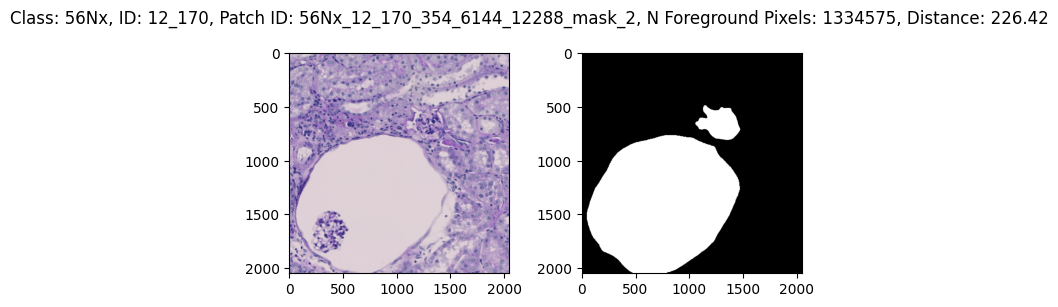

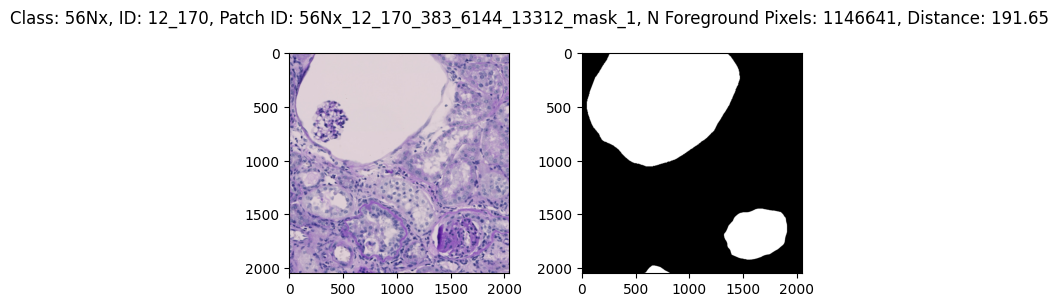

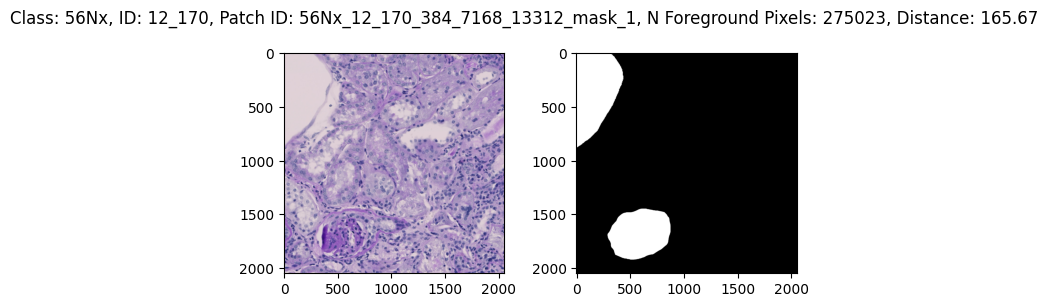

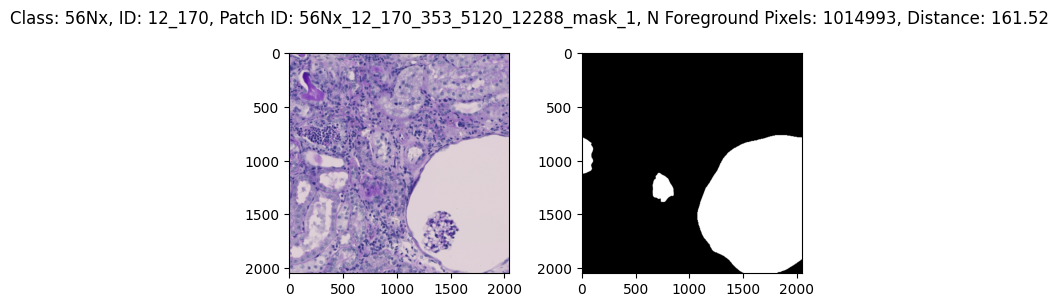

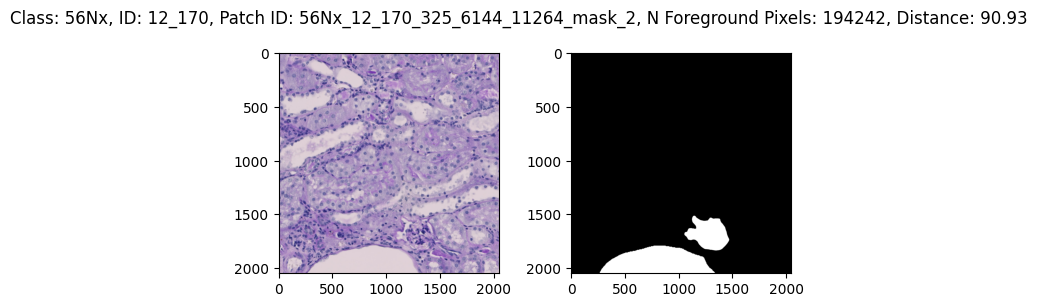

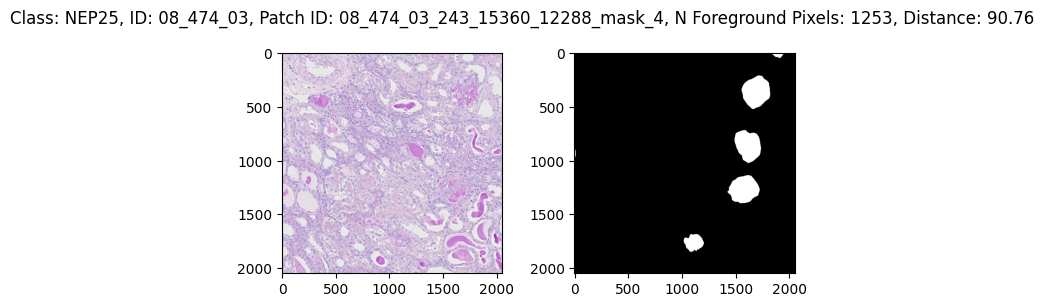

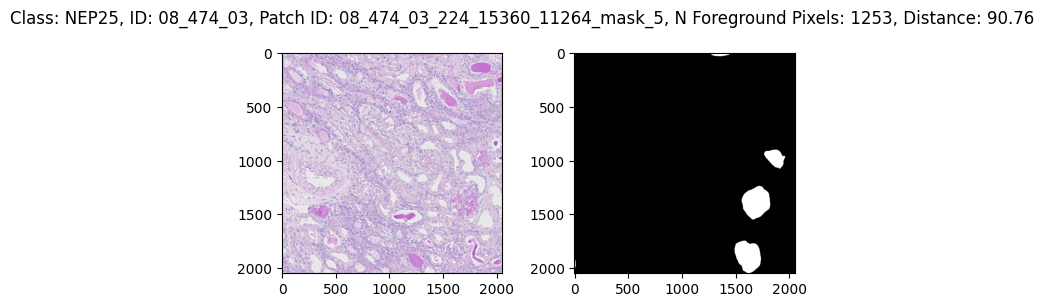

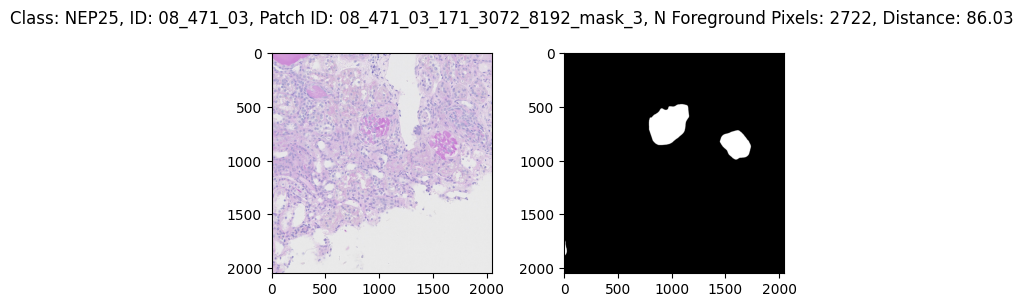

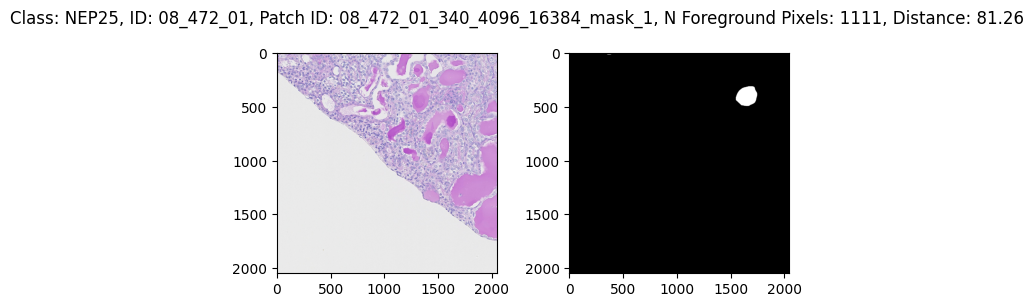

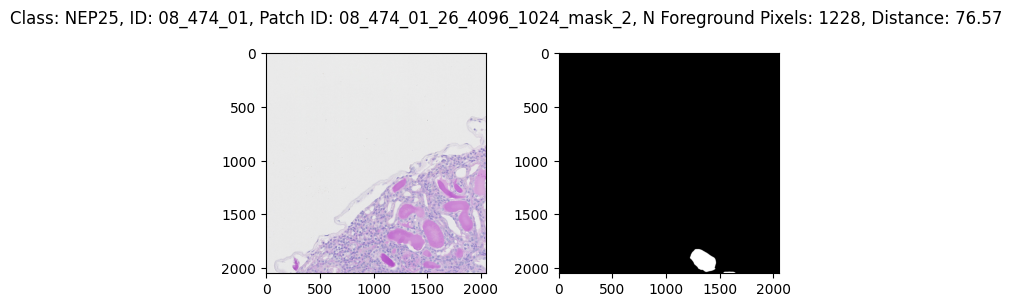

In [16]:
os.makedirs(os.path.join(results_path, 'outliers_train'), exist_ok=True)
#load and plot image and mask in the same subplot for all the outliers in the test set
for i, row in df_train_outliers.iterrows():
    image_path = os.path.join(datapath, row['class'], row['id'], 'img', row['id_patch'].split('_mask')[0] + '_img.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = os.path.join(datapath, row['class'], row['id'], 'mask', row['id_patch'].split('_mask')[0] + '_mask.jpg')
    mask = cv2.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f'Class: {row["class"]}, ID: {row["id"]}, Patch ID: {row["id_patch"]}, N Foreground Pixels: {row["n_foreground_pixels"]}, Distance: {row["distance"]:.2f}')
    ax[0].imshow(image)
    ax[1].imshow(mask)
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(os.path.join(results_path, 'outliers_train', f'{row["class"]}_{row["id"]}_{row["id_patch"]}.jpg'))
    plt.show()